# Vehicle Detection Project

The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier. 
2. Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
3. Run the pipeline on a video stream. 

## 1.Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the produce_dataset.py. I started by reading in all the vehicle and non-vehicle images. Here is an example of one of each of the vehicle and non-vehicle classes:

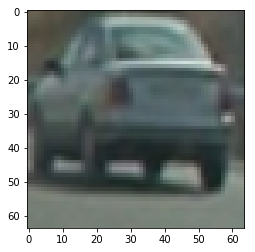

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

image = mpimg.imread('vehicles/GTI_Right/image0035.png')
plt.imshow(image)

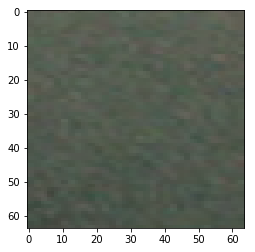

In [2]:
image2 = mpimg.imread('non-vehicles/GTI/image2465.png')
plt.imshow(image2)

I then explored different color spaces and different skimage.hog() parameters (orientations, pixels_per_cell, and cells_per_block). I grabbed random images from each of the two classes and displayed them to get a feel for what the skimage.hog() output looks like.
Here is an example using the YCrCb color space and HOG parameters of orientations=8, pixels_per_cell=(8, 8) and cells_per_block=(2, 2):

In [3]:
import numpy as np
import cv2
from scipy.misc import imresize
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                   visualise=True, feature_vector=feature_vec)
    return features, hog_image

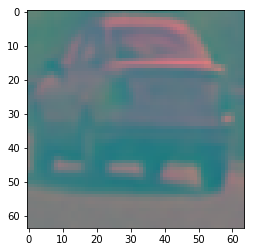

In [4]:
image = mpimg.imread('vehicles/GTI_Right/image0035.png')
image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
plt.imshow(image)

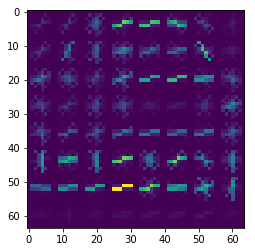

In [5]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

hog_feature1, hog_image = get_hog_features(image[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=True)
plt.imshow(hog_image)

## 2. Explain how you settled on your final choice of HOG parameters.

I explored different color spaces and different skimage.hog() parameters (orientations, pixels_per_cell, and cells_per_block). I read all vehicles and nonvehicles images, and put them together as the dataset. Then, I split the dataset into training dataset(0.8) and validation dataset(0.2). Train linearSVC to see the validation accuracy using different parameters. At last, I find that YCrCb, orient = 9, pix_per_cell = 8, cell_per_block = 2 are best in this case. 

## 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I think that I have already answered this question above. 

## Sliding Window Search
## 1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

The code is in sliding_window.py and process_video.py. First, I only slide the windows in the bottom half of the image because in the top half there will not be vehicles. As I want to use multiple scales of the windows, I then resize the image by the scale parameter. After scaling, I get all hog features in three channels. Then, I slide the window and use linearSVM to predict if the corresponding image is a vehicle or not. 

After I see the six test images, I decide to use five scales which should be able to cover vehicles in different position of the image. The scales are (70, 50), (90, 70), (110, 90), (130, 110) and (200, 130). I rescale these scales to fit the shapes of hogfeatures. I try different overlap windows and decide at last to use (0.8, 0.8) because it has the best performance. 

## 2. Show some examples of test images to demonstrate how your pipeline is working. What did you do to try to minimize false positives and reliably detect cars?

Ultimately I searched on five scales using YCrCb 3-channel HOG features, which provided a satisfying result. Here are some example images:

In [16]:
from sklearn.externals import joblib
from skimage.feature import blob_doh
from scipy import ndimage as ndi
from skimage.morphology import watershed

def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                   visualise=False, feature_vector=feature_vec)
    return features


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return img


def produce_heatmap(prediction, position, scale):
    map = np.zeros([720, 1280])
    for i in range(len(prediction)):

        if prediction[i] > 0:
            map[int(360 + position[i][1] * 8 * scale[1]):int(360 + position[i][3] * 8 * scale[1]), int(position[i][0] * 8 * scale[0]):int(position[i][2] * 8 * scale[0])]+=min(10, prediction[i])
    return map

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, svc, X_scaler, x_start_stop=[0, None], y_start_stop=[0, None],
                    xy_window=(7, 7), xy_overlap=(0.8, 0.8), scale = (1, 1)):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # convert to YcrCb
    image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    image = image[360:, :, :]    #shape 360, 1280, 3

    image = imresize(image, (int(360/scale[1]), int(1280/scale[0]), 3))

    hog_1 = get_hog_features(image[:, :, 0], orient,
                                    pix_per_cell, cell_per_block, feature_vec=False)

    hog_2 = get_hog_features(image[:, :, 1], orient,
                                    pix_per_cell, cell_per_block, feature_vec=False)

    hog_3 = get_hog_features(image[:, :, 2], orient,
                                    pix_per_cell, cell_per_block, feature_vec=False)


    x_start_stop[1] = hog_1.shape[1]
    if y_start_stop[1] == None:
        y_start_stop[1] = hog_1.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    sample_list = []
    position = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            if endy > hog_1.shape[0] or endx > hog_1.shape[1]:
                continue
            hog_feature1 = hog_1[starty:endy, startx:endx:, :, :, :].ravel()
            hog_feature2 = hog_2[starty:endy, startx:endx:, :, :, :].ravel()
            hog_feature3 = hog_3[starty:endy, startx:endx:, :, :, :].ravel()

            features = np.concatenate((hog_feature1, hog_feature2, hog_feature3))
            features = features.reshape(1, -1)
            scaled_features = X_scaler.transform(features)

            sample_list.append(scaled_features.reshape(5292))
            position.append([startx, starty, endx, endy])
            #use a threshold for prediction
    prediction = svc.decision_function(sample_list)

    return produce_heatmap(prediction, position, scale)

def process_image(file):
    svc = joblib.load('svc.pkl')
    X_scaler = joblib.load('X_scaler.pkl')
    image = cv2.imread('test_images/' + file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    windows1 = slide_window(image, svc, X_scaler, x_start_stop=[0, None], y_start_stop=[0, 30],
                            xy_window=(7, 7), xy_overlap=(0.8, 0.8), scale = (1.1, 0.8))

    windows2 = slide_window(image, svc, X_scaler, x_start_stop=[0, None], y_start_stop=[0, 14],
                            xy_window=(7, 7), xy_overlap=(0.8, 0.8), scale=(2, 1.7))

    windows3 = slide_window(image, svc, X_scaler, x_start_stop=[0, None], y_start_stop=[0, None],
                            xy_window=(7, 7), xy_overlap=(0.8, 0.8), scale=(3, 2))

    windows4 = slide_window(image, svc, X_scaler, x_start_stop=[0, None], y_start_stop=[0, 17],
                            xy_window=(7, 7), xy_overlap=(0.8, 0.8), scale=(1.7, 1.4))

    windows5 = slide_window(image, svc, X_scaler, x_start_stop=[0, None], y_start_stop=[0, 10],
                            xy_window=(7, 7), xy_overlap=(0.8, 0.8), scale=(1.4, 1.1))
    heat = windows1 +  windows2 + windows5  + windows3 + windows4

    heat = apply_threshold(heat, min(heat.max()/3 + heat.std()*4,15))

    blobs_doh = blob_doh(heat, min_sigma = 1, max_sigma=50, threshold=.01)

    distance = ndi.distance_transform_edt(heat)
    markers = np.zeros([image.shape[0], image.shape[1]])
    count = 1
    for i in blobs_doh[:, :2]:
        markers[int(i[0]), int(i[1])] = count
        count+=1

    labels = watershed(-distance, markers, mask=heat)
    labels = labels.astype('int')


    window_list = []


    for label in np.unique(labels):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
        if label == 0:
            continue
        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros(heat.shape, dtype="uint8")
        mask[labels == label] = 255
        # detect contours in the mask and grab the largest one
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
        c = max(cnts, key=cv2.contourArea)
        c = cv2.boundingRect(c)
        window_list.append(((c[0], c[1]), (c[0]+c[2], c[1]+c[3])))

    window_img = draw_boxes(image, window_list, color=(0, 0, 255), thick=6)

    fig, axes = plt.subplots(nrows = 2, ncols=2, figsize=(15, 8), sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
    ax0 = axes[0, 0]
    ax1 = axes[0, 1]
    ax2 = axes[1, 0]
    ax3 = axes[1, 1]
    #ax0, ax1, ax2,ax3 = axes

    ax0.imshow(image,  interpolation='nearest')
    ax0.set_title('Original image')
    ax1.imshow(-distance, cmap=plt.cm.jet, interpolation='nearest')
    ax1.set_title('Distances')
    ax2.imshow(labels, cmap=plt.cm.spectral, interpolation='nearest')
    ax2.set_title('Separated objects')
    ax3.imshow(window_img)
    ax3.set_title('Final image')

    plt.imshow(window_img)

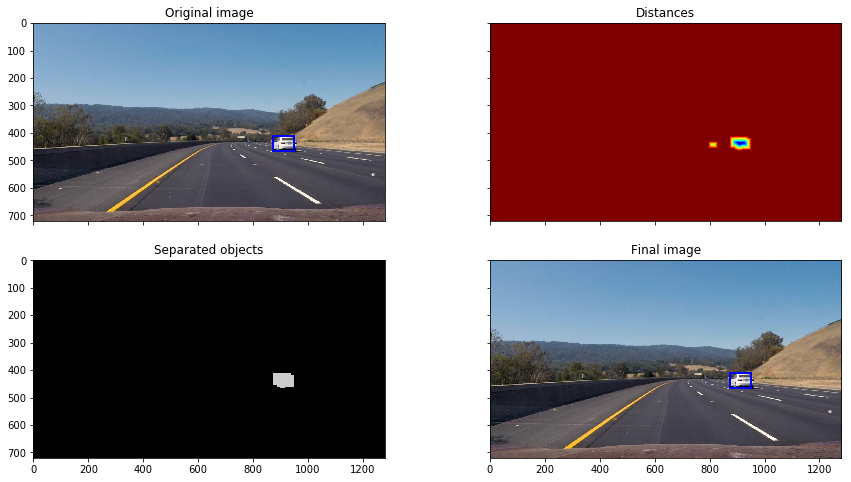

In [17]:
process_image('test3.jpg')

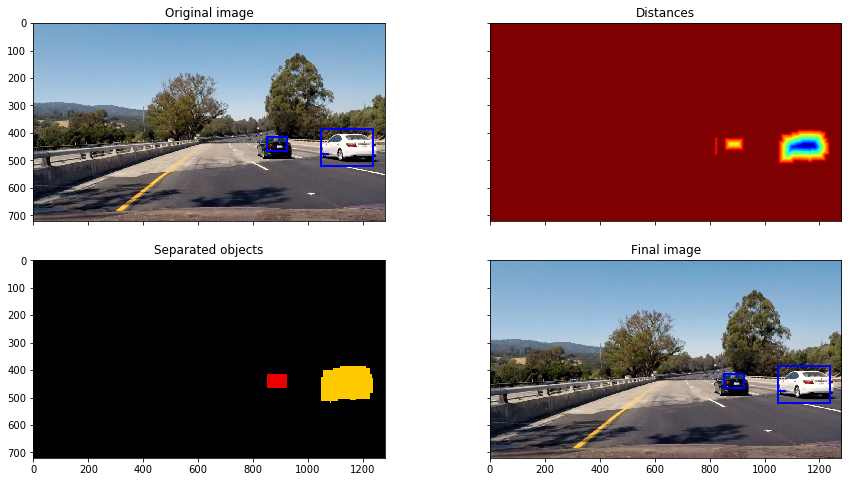

In [18]:
process_image('test4.jpg')

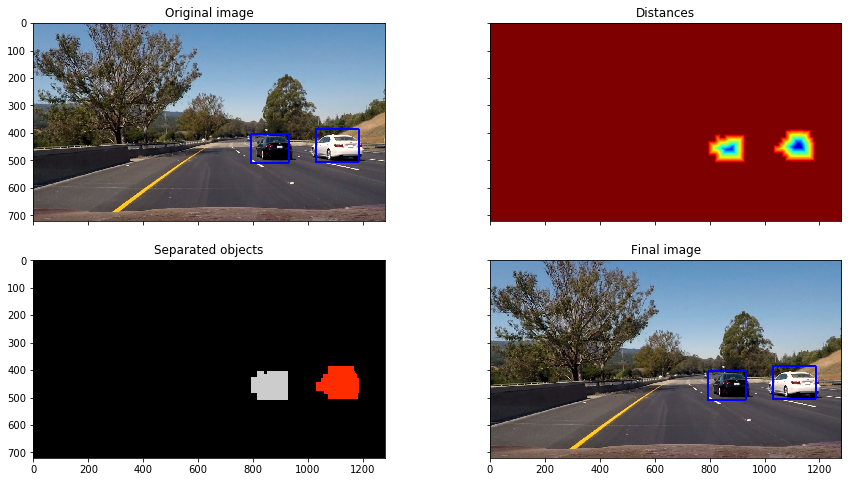

In [19]:
process_image('test6.jpg')

# Video Implementation

## 1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

The video is test.mp4 in the same folder. 

## 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I do the following procedures to deal with overlapping bounding boxes: 
I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used blobs_doh() to identify individual blobs in the heatmap, and use watershed algorithm to find separated vehicles. 

I do the following procedures to deal with false positives: 
(1) Hard negative mining. I download the extra dataset from udacity, and apply the sliding windows and SVM classifier mentioned above to these images. If the window find a positive image, I will compare the bounding box with the vehicle boundary in the .csv file. If it is not a vehicle, I will put it into training dataset. After hard negative mining, I retrain the linearSVM. 

(2) Apply thresholding. I create heatmap using decision_function value. After creating heatmap, I apply a threshold to it to reduce false positives. 

(3) I use class Vehicle() to record the recent bounding boxes. For each bounding boxes, I record count1 and count2. count1 represents the number of frames that this 'vehicle' appears. count2 represents the number of frames that this 'vehicle' disappears. While processing each frame, when we have a positive detection, I will compare the bounding box with the recorded bounding boxes. If their centroids are close to each other, they are considered to be the same 'vehicle', then I set count1 += 1 and count2 -=2. In this case, the bounding box is also averaged. In each frame, I also make count2 -=1. 

At last, for each recorded bounding boxes, if count1 >= 15, I will draw the box in the image. If count2 >= 25, I will delete the bounding box in the recorded list. In this way, most false positives will be reduced because they do not tend to appear in so many frames. 

# Discussion

## 1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

There are several important problems in the pipeline:
(1) False positives. I think that false positives are the most serious problem. I have already discussed what I do to deal with false positives. However, it still appears sometimes in the video. I think that I have applied a series of tricks to reduce false positives after sliding window. Maybe I should spend more time on the classfier itself(try to use a more accurate classifier). 
(2) False negatives. There are some cases that the classifier cannot recognize the vehicles(like the first moment two vehicles appear in the video). To deal with this, I try to tune the hyperparameters and also use more sliding windows with different scales. Also, I have made the overlap window large. A better tuned threshold and a better classifier might help.
(3) The speed is quite slow(about 6 - 8s/it) which is far from real-time detection and tracking. To deal with this, I have already done something like extracing the hog feature once for the whole image. However, this is far from enough. I think that use label() to replace blob_doh() and watershed() might help. In addition, a better classifier like CNN might improve the performance as well as speed. 
(4) When two vehicles are close to each other, the bounding boxes will be combined to one. A better algorihtm than watershed might help seperate them better. 
(5) The size of the bounding boxes is not very stable. I think that for a certain area of the image, we may try to use a fix size of bounding box. For example, if the vehicle appears in the middle of the image, we might want to use a small size bounding box. In this case, after we detect all the vehicles, we use the detected centroids and fixed size windows to draw bounding boxes. 

To be honest, I have met a lot of difficulty in this project, but in the meantime, I also learn a lot from it although the performance is far from perfect. 